In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='7'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC = 'combined'
SAMPLE_SIZE=10000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
MAX_TEMP_PROFILE_LIST = '/workspace/outputs/profiles_v1_experiment_3_20250327_0208/profile_list_v1_max_temp_10000.json'
MIN_TEMP_PROFILE_LIST = '/workspace/outputs/profiles_v1_experiment_4_20250327_0313/profile_list_v1_min_temp_10000.json'
STD_TEMP_PROFILE_LIST = '/workspace/outputs/profiles_v1_experiment_6_20250327_0550/profile_list_v1_std_temp_10000.json'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_7_20250328_0125


In [3]:
# * * * * * * * * * * * * * * * *
# Load and Combine Profile List
# * * * * * * * * * * * * * * * *
max_profile_list = LoadProfileList(MAX_TEMP_PROFILE_LIST)
min_profile_list = LoadProfileList(MIN_TEMP_PROFILE_LIST)
std_profile_list = LoadProfileList(STD_TEMP_PROFILE_LIST)
profile_list = list(set(max_profile_list + min_profile_list + std_profile_list))

In [4]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 672245/672245 [03:15<00:00, 3440.12it/s]

Saved 672245 profiles to /workspace/outputs/profiles_v1_experiment_7_20250328_0125/20250328-dataset.csv


In [5]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 672245it [00:27, 24669.54it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250328_0125/density_plot.png


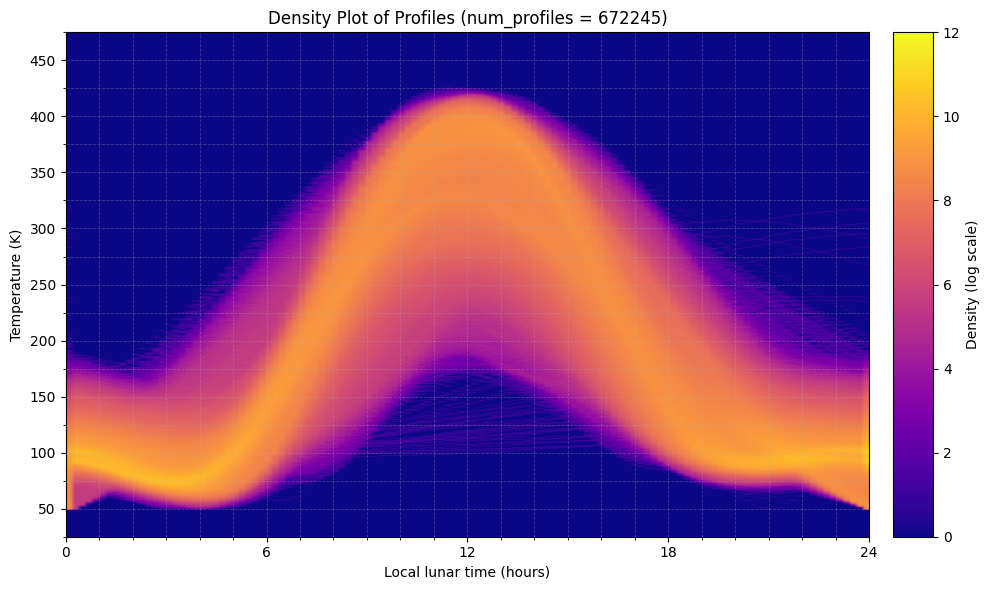

In [6]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [7]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250328_0125/histogram_max_temp.png


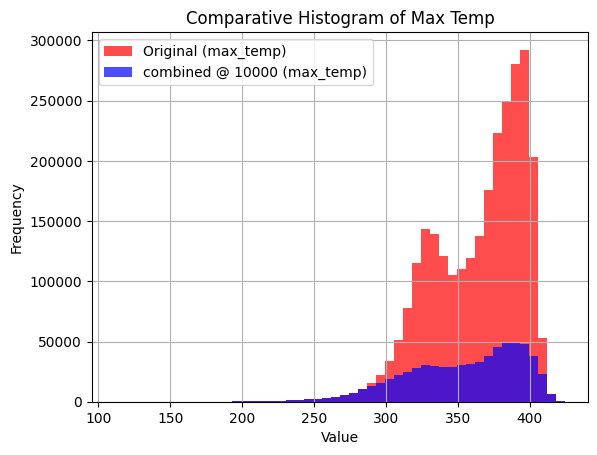

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250328_0125/histogram_min_temp.png


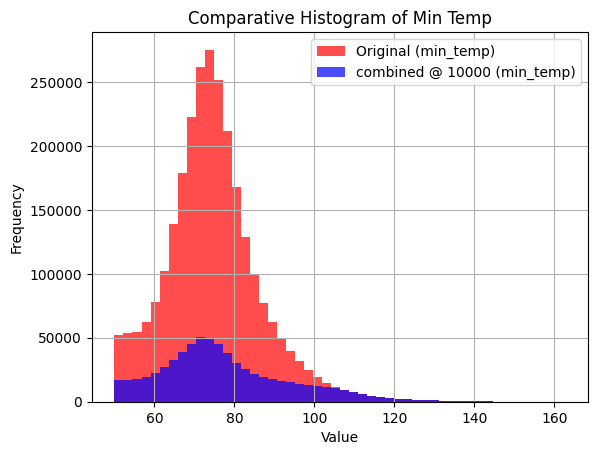

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250328_0125/histogram_mean_temp.png


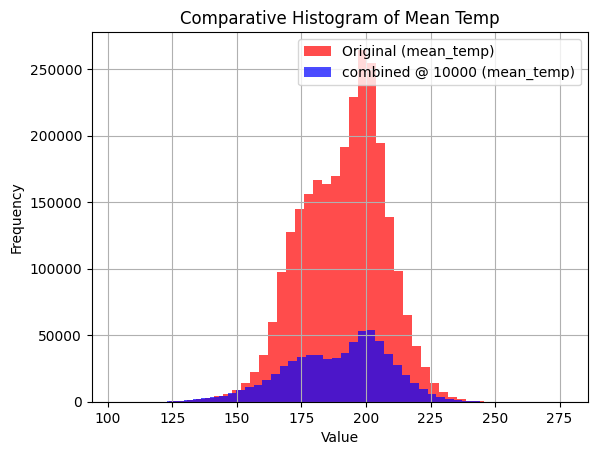

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250328_0125/histogram_std_temp.png


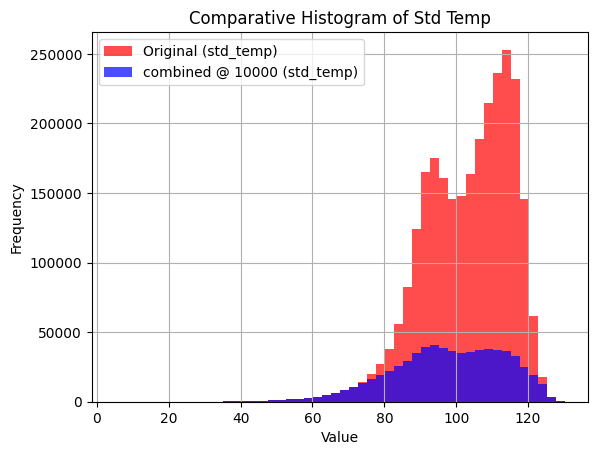

In [8]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [9]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 189.1484
STD: 100.9797
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 470571
Validation Data: 134449
Test Data: 67225


In [10]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [11]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 2353/2353 [01:20<00:00, 29.41it/s, best_loss=0.5753]


[Training] Epoch 1/100, L1 Loss: 0.5771, L2 Loss: 0.5832, KL Loss: 0.6038, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 673/673 [00:07<00:00, 92.54it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5159, Val L2 Loss: 0.5119, Val KL Loss: 0.6287
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250328_0125'


[Training] Epoch 2/100: 100%|██████████| 2353/2353 [01:20<00:00, 29.29it/s, best_loss=0.5613]


[Training] Epoch 2/100, L1 Loss: 0.5591, L2 Loss: 0.5575, KL Loss: 0.6335, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 673/673 [00:06<00:00, 98.97it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.5117, Val L2 Loss: 0.5090, Val KL Loss: 0.6214
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250328_0125'


[Training] Epoch 3/100: 100%|██████████| 2353/2353 [01:21<00:00, 28.74it/s, best_loss=0.5562]


[Training] Epoch 3/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6348, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 673/673 [00:06<00:00, 99.62it/s] 


[Validation] Epoch 3/100, Val L1 Loss: 0.5119, Val L2 Loss: 0.5089, Val KL Loss: 0.6277


[Training] Epoch 4/100: 100%|██████████| 2353/2353 [01:22<00:00, 28.50it/s, best_loss=0.5530]


[Training] Epoch 4/100, L1 Loss: 0.5578, L2 Loss: 0.5558, KL Loss: 0.6345, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 673/673 [00:06<00:00, 97.42it/s] 


[Validation] Epoch 4/100, Val L1 Loss: 0.5108, Val L2 Loss: 0.5080, Val KL Loss: 0.6306
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250328_0125'


[Training] Epoch 5/100: 100%|██████████| 2353/2353 [01:20<00:00, 29.17it/s, best_loss=0.5588]


[Training] Epoch 5/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 673/673 [00:06<00:00, 97.75it/s] 


[Validation] Epoch 5/100, Val L1 Loss: 0.5062, Val L2 Loss: 0.5048, Val KL Loss: 0.6408
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250328_0125'


[Training] Epoch 6/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.41it/s, best_loss=0.5593]


[Training] Epoch 6/100, L1 Loss: 0.5578, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 673/673 [00:06<00:00, 105.37it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5124, Val L2 Loss: 0.5094, Val KL Loss: 0.6255


[Training] Epoch 7/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.56it/s, best_loss=0.5548]


[Training] Epoch 7/100, L1 Loss: 0.5578, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 673/673 [00:06<00:00, 107.74it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5106, Val L2 Loss: 0.5081, Val KL Loss: 0.6314


[Training] Epoch 8/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.62it/s, best_loss=0.5518]


[Training] Epoch 8/100, L1 Loss: 0.5578, L2 Loss: 0.5558, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 673/673 [00:06<00:00, 99.71it/s] 


[Validation] Epoch 8/100, Val L1 Loss: 0.5137, Val L2 Loss: 0.5104, Val KL Loss: 0.6199


[Training] Epoch 9/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.42it/s, best_loss=0.5569]


[Training] Epoch 9/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 673/673 [00:06<00:00, 99.62it/s] 


[Validation] Epoch 9/100, Val L1 Loss: 0.5116, Val L2 Loss: 0.5089, Val KL Loss: 0.6236


[Training] Epoch 10/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.47it/s, best_loss=0.5698]


[Training] Epoch 10/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 673/673 [00:06<00:00, 104.69it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5108, Val L2 Loss: 0.5083, Val KL Loss: 0.6302


[Training] Epoch 11/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.56it/s, best_loss=0.5605]


[Training] Epoch 11/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 673/673 [00:07<00:00, 95.10it/s] 


[Validation] Epoch 11/100, Val L1 Loss: 0.5121, Val L2 Loss: 0.5092, Val KL Loss: 0.6255


[Training] Epoch 12/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.53it/s, best_loss=0.5631]


[Training] Epoch 12/100, L1 Loss: 0.5577, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 673/673 [00:06<00:00, 98.37it/s] 


[Validation] Epoch 12/100, Val L1 Loss: 0.5079, Val L2 Loss: 0.5062, Val KL Loss: 0.6384


[Training] Epoch 13/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.74it/s, best_loss=0.5587]


[Training] Epoch 13/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 673/673 [00:06<00:00, 106.12it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5090, Val L2 Loss: 0.5068, Val KL Loss: 0.6301


[Training] Epoch 14/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.77it/s, best_loss=0.5415]


[Training] Epoch 14/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 673/673 [00:06<00:00, 102.47it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5114, Val L2 Loss: 0.5088, Val KL Loss: 0.6228


[Training] Epoch 15/100: 100%|██████████| 2353/2353 [01:15<00:00, 31.34it/s, best_loss=0.5717]


[Training] Epoch 15/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 673/673 [00:06<00:00, 100.47it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5070, Val L2 Loss: 0.5053, Val KL Loss: 0.6396


[Training] Epoch 16/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.77it/s, best_loss=0.5575]


[Training] Epoch 16/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 673/673 [00:06<00:00, 107.74it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5077, Val L2 Loss: 0.5062, Val KL Loss: 0.6368


[Training] Epoch 17/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.91it/s, best_loss=0.5483]


[Training] Epoch 17/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 673/673 [00:06<00:00, 110.47it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5075, Val L2 Loss: 0.5058, Val KL Loss: 0.6390


[Training] Epoch 18/100: 100%|██████████| 2353/2353 [01:15<00:00, 30.96it/s, best_loss=0.5500]


[Training] Epoch 18/100, L1 Loss: 0.5578, L2 Loss: 0.5558, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 673/673 [00:06<00:00, 109.85it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5074, Val L2 Loss: 0.5058, Val KL Loss: 0.6429


[Training] Epoch 19/100: 100%|██████████| 2353/2353 [01:15<00:00, 31.04it/s, best_loss=0.5460]


[Training] Epoch 19/100, L1 Loss: 0.5580, L2 Loss: 0.5561, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 673/673 [00:06<00:00, 107.20it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5098, Val L2 Loss: 0.5075, Val KL Loss: 0.6342


[Training] Epoch 20/100: 100%|██████████| 2353/2353 [01:15<00:00, 31.10it/s, best_loss=0.5471]


[Training] Epoch 20/100, L1 Loss: 0.5580, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 673/673 [00:06<00:00, 101.84it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5090, Val L2 Loss: 0.5068, Val KL Loss: 0.6375


[Training] Epoch 21/100: 100%|██████████| 2353/2353 [01:15<00:00, 31.10it/s, best_loss=0.5664]


[Training] Epoch 21/100, L1 Loss: 0.5580, L2 Loss: 0.5563, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 673/673 [00:06<00:00, 97.37it/s] 


[Validation] Epoch 21/100, Val L1 Loss: 0.5169, Val L2 Loss: 0.5129, Val KL Loss: 0.6127


[Training] Epoch 22/100: 100%|██████████| 2353/2353 [01:15<00:00, 31.26it/s, best_loss=0.5457]


[Training] Epoch 22/100, L1 Loss: 0.5578, L2 Loss: 0.5558, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 673/673 [00:06<00:00, 109.69it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5070, Val L2 Loss: 0.5055, Val KL Loss: 0.6386


[Training] Epoch 23/100: 100%|██████████| 2353/2353 [01:15<00:00, 31.30it/s, best_loss=0.5572]


[Training] Epoch 23/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 673/673 [00:06<00:00, 109.06it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.5072, Val KL Loss: 0.6385


[Training] Epoch 24/100: 100%|██████████| 2353/2353 [01:15<00:00, 31.22it/s, best_loss=0.5527]


[Training] Epoch 24/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 673/673 [00:06<00:00, 104.16it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5097, Val L2 Loss: 0.5074, Val KL Loss: 0.6305


[Training] Epoch 25/100: 100%|██████████| 2353/2353 [01:14<00:00, 31.42it/s, best_loss=0.5708]


[Training] Epoch 25/100, L1 Loss: 0.5581, L2 Loss: 0.5563, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 673/673 [00:06<00:00, 97.88it/s] 


[Validation] Epoch 25/100, Val L1 Loss: 0.5079, Val L2 Loss: 0.5061, Val KL Loss: 0.6408


[Training] Epoch 26/100: 100%|██████████| 2353/2353 [01:15<00:00, 30.99it/s, best_loss=0.5589]


[Training] Epoch 26/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 673/673 [00:06<00:00, 110.07it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5097, Val L2 Loss: 0.5074, Val KL Loss: 0.6308


[Training] Epoch 27/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.75it/s, best_loss=0.5522]


[Training] Epoch 27/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 673/673 [00:06<00:00, 97.33it/s] 


[Validation] Epoch 27/100, Val L1 Loss: 0.5100, Val L2 Loss: 0.5079, Val KL Loss: 0.6319


[Training] Epoch 28/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.91it/s, best_loss=0.5575]


[Training] Epoch 28/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 673/673 [00:06<00:00, 102.90it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5143, Val L2 Loss: 0.5108, Val KL Loss: 0.6193


[Training] Epoch 29/100: 100%|██████████| 2353/2353 [01:15<00:00, 31.19it/s, best_loss=0.5522]


[Training] Epoch 29/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 673/673 [00:06<00:00, 101.61it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5084, Val L2 Loss: 0.5068, Val KL Loss: 0.6356


[Training] Epoch 30/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.87it/s, best_loss=0.5543]


[Training] Epoch 30/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 673/673 [00:06<00:00, 99.38it/s] 


[Validation] Epoch 30/100, Val L1 Loss: 0.5067, Val L2 Loss: 0.5052, Val KL Loss: 0.6430


[Training] Epoch 31/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.74it/s, best_loss=0.5496]


[Training] Epoch 31/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 673/673 [00:06<00:00, 101.46it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5084, Val L2 Loss: 0.5064, Val KL Loss: 0.6383


[Training] Epoch 32/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.82it/s, best_loss=0.5593]


[Training] Epoch 32/100, L1 Loss: 0.5581, L2 Loss: 0.5563, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 673/673 [00:06<00:00, 106.34it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5105, Val L2 Loss: 0.5082, Val KL Loss: 0.6261


[Training] Epoch 33/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.37it/s, best_loss=0.5554]


[Training] Epoch 33/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 673/673 [00:06<00:00, 104.90it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.5070, Val KL Loss: 0.6359


[Training] Epoch 34/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.48it/s, best_loss=0.5657]


[Training] Epoch 34/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 673/673 [00:06<00:00, 101.87it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5072, Val L2 Loss: 0.5055, Val KL Loss: 0.6397


[Training] Epoch 35/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.47it/s, best_loss=0.5569]


[Training] Epoch 35/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 673/673 [00:06<00:00, 102.73it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5070, Val L2 Loss: 0.5055, Val KL Loss: 0.6416


[Training] Epoch 36/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.71it/s, best_loss=0.5642]


[Training] Epoch 36/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 673/673 [00:06<00:00, 104.28it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5132, Val L2 Loss: 0.5100, Val KL Loss: 0.6223


[Training] Epoch 37/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.59it/s, best_loss=0.5640]


[Training] Epoch 37/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 673/673 [00:06<00:00, 101.36it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5110, Val L2 Loss: 0.5082, Val KL Loss: 0.6283


[Training] Epoch 38/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.44it/s, best_loss=0.5536]


[Training] Epoch 38/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 673/673 [00:06<00:00, 102.71it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5091, Val L2 Loss: 0.5067, Val KL Loss: 0.6341


[Training] Epoch 39/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.41it/s, best_loss=0.5585]


[Training] Epoch 39/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 673/673 [00:06<00:00, 106.77it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5063, Val L2 Loss: 0.5049, Val KL Loss: 0.6424


[Training] Epoch 40/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.41it/s, best_loss=0.5626]


[Training] Epoch 40/100, L1 Loss: 0.5577, L2 Loss: 0.5558, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 673/673 [00:06<00:00, 99.25it/s] 


[Validation] Epoch 40/100, Val L1 Loss: 0.5101, Val L2 Loss: 0.5077, Val KL Loss: 0.6321


[Training] Epoch 41/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.34it/s, best_loss=0.5718]


[Training] Epoch 41/100, L1 Loss: 0.5580, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 673/673 [00:06<00:00, 98.36it/s] 


[Validation] Epoch 41/100, Val L1 Loss: 0.5117, Val L2 Loss: 0.5090, Val KL Loss: 0.6275


[Training] Epoch 42/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.59it/s, best_loss=0.5627]


[Training] Epoch 42/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 673/673 [00:06<00:00, 109.12it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5097, Val L2 Loss: 0.5074, Val KL Loss: 0.6317


[Training] Epoch 43/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.27it/s, best_loss=0.5591]


[Training] Epoch 43/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 673/673 [00:06<00:00, 96.20it/s] 


[Validation] Epoch 43/100, Val L1 Loss: 0.5106, Val L2 Loss: 0.5080, Val KL Loss: 0.6291


[Training] Epoch 44/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.64it/s, best_loss=0.5575]


[Training] Epoch 44/100, L1 Loss: 0.5581, L2 Loss: 0.5562, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 673/673 [00:06<00:00, 102.55it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5074, Val L2 Loss: 0.5058, Val KL Loss: 0.6408


[Training] Epoch 45/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.34it/s, best_loss=0.5605]


[Training] Epoch 45/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 673/673 [00:06<00:00, 107.44it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5080, Val L2 Loss: 0.5062, Val KL Loss: 0.6362


[Training] Epoch 46/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.53it/s, best_loss=0.5715]


[Training] Epoch 46/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 673/673 [00:06<00:00, 100.10it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5094, Val L2 Loss: 0.5073, Val KL Loss: 0.6330


[Training] Epoch 47/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.61it/s, best_loss=0.5657]


[Training] Epoch 47/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 673/673 [00:06<00:00, 107.87it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5140, Val L2 Loss: 0.5105, Val KL Loss: 0.6230


[Training] Epoch 48/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.54it/s, best_loss=0.5608]


[Training] Epoch 48/100, L1 Loss: 0.5578, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 673/673 [00:06<00:00, 105.50it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5082, Val L2 Loss: 0.5064, Val KL Loss: 0.6389


[Training] Epoch 49/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.44it/s, best_loss=0.5625]


[Training] Epoch 49/100, L1 Loss: 0.5578, L2 Loss: 0.5560, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 673/673 [00:06<00:00, 107.28it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5096, Val L2 Loss: 0.5075, Val KL Loss: 0.6318


[Training] Epoch 50/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.19it/s, best_loss=0.5778]


[Training] Epoch 50/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 673/673 [00:06<00:00, 101.98it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5096, Val L2 Loss: 0.5073, Val KL Loss: 0.6329


[Training] Epoch 51/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.61it/s, best_loss=0.5561]


[Training] Epoch 51/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 673/673 [00:06<00:00, 97.61it/s] 


[Validation] Epoch 51/100, Val L1 Loss: 0.5100, Val L2 Loss: 0.5077, Val KL Loss: 0.6284


[Training] Epoch 52/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.66it/s, best_loss=0.5585]


[Training] Epoch 52/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 673/673 [00:06<00:00, 101.16it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5067, Val L2 Loss: 0.5052, Val KL Loss: 0.6421


[Training] Epoch 53/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.36it/s, best_loss=0.5640]


[Training] Epoch 53/100, L1 Loss: 0.5581, L2 Loss: 0.5563, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 673/673 [00:06<00:00, 103.75it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5096, Val L2 Loss: 0.5074, Val KL Loss: 0.6290


[Training] Epoch 54/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.64it/s, best_loss=0.5546]


[Training] Epoch 54/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 673/673 [00:06<00:00, 103.84it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5113, Val L2 Loss: 0.5086, Val KL Loss: 0.6248


[Training] Epoch 55/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.57it/s, best_loss=0.5484]


[Training] Epoch 55/100, L1 Loss: 0.5577, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 673/673 [00:06<00:00, 105.53it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5107, Val L2 Loss: 0.5083, Val KL Loss: 0.6326


[Training] Epoch 56/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.61it/s, best_loss=0.5503]


[Training] Epoch 56/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 673/673 [00:06<00:00, 106.94it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5072, Val L2 Loss: 0.5056, Val KL Loss: 0.6450


[Training] Epoch 57/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.19it/s, best_loss=0.5667]


[Training] Epoch 57/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 673/673 [00:07<00:00, 93.20it/s] 


[Validation] Epoch 57/100, Val L1 Loss: 0.5049, Val L2 Loss: 0.5039, Val KL Loss: 0.6442
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250328_0125'


[Training] Epoch 58/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.49it/s, best_loss=0.5565]


[Training] Epoch 58/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 673/673 [00:06<00:00, 99.40it/s] 


[Validation] Epoch 58/100, Val L1 Loss: 0.5109, Val L2 Loss: 0.5083, Val KL Loss: 0.6289


[Training] Epoch 59/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.46it/s, best_loss=0.5556]


[Training] Epoch 59/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 673/673 [00:06<00:00, 98.74it/s] 


[Validation] Epoch 59/100, Val L1 Loss: 0.5133, Val L2 Loss: 0.5101, Val KL Loss: 0.6211


[Training] Epoch 60/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.28it/s, best_loss=0.5600]


[Training] Epoch 60/100, L1 Loss: 0.5577, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 673/673 [00:07<00:00, 93.70it/s] 


[Validation] Epoch 60/100, Val L1 Loss: 0.5109, Val L2 Loss: 0.5080, Val KL Loss: 0.6355


[Training] Epoch 61/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.63it/s, best_loss=0.5624]


[Training] Epoch 61/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 673/673 [00:06<00:00, 106.32it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5073, Val L2 Loss: 0.5057, Val KL Loss: 0.6432


[Training] Epoch 62/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.68it/s, best_loss=0.5730]


[Training] Epoch 62/100, L1 Loss: 0.5581, L2 Loss: 0.5563, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 673/673 [00:06<00:00, 101.18it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5104, Val L2 Loss: 0.5079, Val KL Loss: 0.6261


[Training] Epoch 63/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.50it/s, best_loss=0.5390]


[Training] Epoch 63/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 673/673 [00:06<00:00, 101.81it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5095, Val L2 Loss: 0.5072, Val KL Loss: 0.6343


[Training] Epoch 64/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.80it/s, best_loss=0.5554]


[Training] Epoch 64/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 673/673 [00:07<00:00, 95.59it/s] 


[Validation] Epoch 64/100, Val L1 Loss: 0.5103, Val L2 Loss: 0.5078, Val KL Loss: 0.6315


[Training] Epoch 65/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.36it/s, best_loss=0.5446]


[Training] Epoch 65/100, L1 Loss: 0.5577, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 673/673 [00:06<00:00, 106.02it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5110, Val L2 Loss: 0.5084, Val KL Loss: 0.6291


[Training] Epoch 66/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.51it/s, best_loss=0.5404]


[Training] Epoch 66/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 673/673 [00:06<00:00, 100.80it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5104, Val L2 Loss: 0.5079, Val KL Loss: 0.6292


[Training] Epoch 67/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.53it/s, best_loss=0.5578]


[Training] Epoch 67/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 673/673 [00:06<00:00, 104.35it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5122, Val L2 Loss: 0.5093, Val KL Loss: 0.6238


[Training] Epoch 68/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.76it/s, best_loss=0.5595]


[Training] Epoch 68/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 673/673 [00:06<00:00, 102.59it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5079, Val L2 Loss: 0.5061, Val KL Loss: 0.6385


[Training] Epoch 69/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.49it/s, best_loss=0.5608]


[Training] Epoch 69/100, L1 Loss: 0.5580, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 673/673 [00:06<00:00, 105.15it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5155, Val L2 Loss: 0.5118, Val KL Loss: 0.6195


[Training] Epoch 70/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.30it/s, best_loss=0.5525]


[Training] Epoch 70/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 673/673 [00:06<00:00, 98.61it/s] 


[Validation] Epoch 70/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.5071, Val KL Loss: 0.6349


[Training] Epoch 71/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.40it/s, best_loss=0.5719]


[Training] Epoch 71/100, L1 Loss: 0.5579, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 673/673 [00:06<00:00, 106.41it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5069, Val L2 Loss: 0.5053, Val KL Loss: 0.6406


[Training] Epoch 72/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.28it/s, best_loss=0.5663]


[Training] Epoch 72/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 673/673 [00:06<00:00, 101.29it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5098, Val L2 Loss: 0.5072, Val KL Loss: 0.6320


[Training] Epoch 73/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.31it/s, best_loss=0.5515]


[Training] Epoch 73/100, L1 Loss: 0.5577, L2 Loss: 0.5558, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 673/673 [00:06<00:00, 103.02it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5088, Val L2 Loss: 0.5068, Val KL Loss: 0.6389


[Training] Epoch 74/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.42it/s, best_loss=0.5379]


[Training] Epoch 74/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 673/673 [00:06<00:00, 104.88it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5090, Val L2 Loss: 0.5070, Val KL Loss: 0.6288


[Training] Epoch 75/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.46it/s, best_loss=0.5597]


[Training] Epoch 75/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 673/673 [00:06<00:00, 106.49it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5083, Val L2 Loss: 0.5064, Val KL Loss: 0.6372


[Training] Epoch 76/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.45it/s, best_loss=0.5524]


[Training] Epoch 76/100, L1 Loss: 0.5580, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 673/673 [00:06<00:00, 101.70it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5102, Val L2 Loss: 0.5077, Val KL Loss: 0.6315


[Training] Epoch 77/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.60it/s, best_loss=0.5569]


[Training] Epoch 77/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 673/673 [00:06<00:00, 102.70it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.5070, Val KL Loss: 0.6324


[Training] Epoch 78/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.39it/s, best_loss=0.5651]


[Training] Epoch 78/100, L1 Loss: 0.5580, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 673/673 [00:06<00:00, 99.99it/s] 


[Validation] Epoch 78/100, Val L1 Loss: 0.5062, Val L2 Loss: 0.5047, Val KL Loss: 0.6439


[Training] Epoch 79/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.32it/s, best_loss=0.5618]


[Training] Epoch 79/100, L1 Loss: 0.5578, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 673/673 [00:06<00:00, 101.58it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5066, Val L2 Loss: 0.5052, Val KL Loss: 0.6361


[Training] Epoch 80/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.40it/s, best_loss=0.5624]


[Training] Epoch 80/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 673/673 [00:06<00:00, 100.06it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5078, Val L2 Loss: 0.5061, Val KL Loss: 0.6370


[Training] Epoch 81/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.43it/s, best_loss=0.5417]


[Training] Epoch 81/100, L1 Loss: 0.5578, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 673/673 [00:06<00:00, 97.87it/s] 


[Validation] Epoch 81/100, Val L1 Loss: 0.5098, Val L2 Loss: 0.5077, Val KL Loss: 0.6354


[Training] Epoch 82/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.55it/s, best_loss=0.5625]


[Training] Epoch 82/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 673/673 [00:06<00:00, 101.60it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5113, Val L2 Loss: 0.5086, Val KL Loss: 0.6303


[Training] Epoch 83/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.58it/s, best_loss=0.5731]


[Training] Epoch 83/100, L1 Loss: 0.5578, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 673/673 [00:06<00:00, 103.69it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5102, Val L2 Loss: 0.5079, Val KL Loss: 0.6307


[Training] Epoch 84/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.76it/s, best_loss=0.5517]


[Training] Epoch 84/100, L1 Loss: 0.5579, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 673/673 [00:06<00:00, 105.05it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5104, Val L2 Loss: 0.5082, Val KL Loss: 0.6307


[Training] Epoch 85/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.68it/s, best_loss=0.5537]


[Training] Epoch 85/100, L1 Loss: 0.5580, L2 Loss: 0.5562, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 673/673 [00:06<00:00, 103.89it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5141, Val L2 Loss: 0.5107, Val KL Loss: 0.6224


[Training] Epoch 86/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.68it/s, best_loss=0.5593]


[Training] Epoch 86/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 673/673 [00:06<00:00, 97.86it/s] 


[Validation] Epoch 86/100, Val L1 Loss: 0.5104, Val L2 Loss: 0.5081, Val KL Loss: 0.6283


[Training] Epoch 87/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.83it/s, best_loss=0.5402]


[Training] Epoch 87/100, L1 Loss: 0.5577, L2 Loss: 0.5559, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 673/673 [00:06<00:00, 110.58it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5084, Val L2 Loss: 0.5065, Val KL Loss: 0.6383


[Training] Epoch 88/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.89it/s, best_loss=0.5589]


[Training] Epoch 88/100, L1 Loss: 0.5580, L2 Loss: 0.5561, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 673/673 [00:06<00:00, 108.34it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5110, Val L2 Loss: 0.5084, Val KL Loss: 0.6302


[Training] Epoch 89/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.87it/s, best_loss=0.5602]


[Training] Epoch 89/100, L1 Loss: 0.5582, L2 Loss: 0.5564, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 673/673 [00:06<00:00, 100.51it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5119, Val L2 Loss: 0.5090, Val KL Loss: 0.6214


[Training] Epoch 90/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.93it/s, best_loss=0.5651]


[Training] Epoch 90/100, L1 Loss: 0.5580, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 673/673 [00:06<00:00, 101.31it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5150, Val L2 Loss: 0.5113, Val KL Loss: 0.6234


[Training] Epoch 91/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.96it/s, best_loss=0.5586]


[Training] Epoch 91/100, L1 Loss: 0.5580, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 673/673 [00:06<00:00, 110.08it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5097, Val L2 Loss: 0.5075, Val KL Loss: 0.6310


[Training] Epoch 92/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.75it/s, best_loss=0.5661]


[Training] Epoch 92/100, L1 Loss: 0.5579, L2 Loss: 0.5561, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 673/673 [00:06<00:00, 99.07it/s] 


[Validation] Epoch 92/100, Val L1 Loss: 0.5084, Val L2 Loss: 0.5067, Val KL Loss: 0.6355


[Training] Epoch 93/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.90it/s, best_loss=0.5706]


[Training] Epoch 93/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 673/673 [00:06<00:00, 106.31it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5134, Val L2 Loss: 0.5101, Val KL Loss: 0.6225


[Training] Epoch 94/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.90it/s, best_loss=0.5599]


[Training] Epoch 94/100, L1 Loss: 0.5576, L2 Loss: 0.5558, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 673/673 [00:06<00:00, 106.84it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5123, Val L2 Loss: 0.5094, Val KL Loss: 0.6224


[Training] Epoch 95/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.86it/s, best_loss=0.5569]


[Training] Epoch 95/100, L1 Loss: 0.5581, L2 Loss: 0.5562, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 673/673 [00:06<00:00, 100.44it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5136, Val L2 Loss: 0.5104, Val KL Loss: 0.6243


[Training] Epoch 96/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.68it/s, best_loss=0.5511]


[Training] Epoch 96/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 673/673 [00:06<00:00, 102.46it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5101, Val L2 Loss: 0.5075, Val KL Loss: 0.6311


[Training] Epoch 97/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.73it/s, best_loss=0.5585]


[Training] Epoch 97/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6341, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 673/673 [00:06<00:00, 105.12it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5088, Val L2 Loss: 0.5068, Val KL Loss: 0.6339


[Training] Epoch 98/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.38it/s, best_loss=0.5602]


[Training] Epoch 98/100, L1 Loss: 0.5578, L2 Loss: 0.5559, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 673/673 [00:06<00:00, 108.31it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5120, Val L2 Loss: 0.5089, Val KL Loss: 0.6272


[Training] Epoch 99/100: 100%|██████████| 2353/2353 [01:16<00:00, 30.64it/s, best_loss=0.5591]


[Training] Epoch 99/100, L1 Loss: 0.5580, L2 Loss: 0.5561, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 673/673 [00:06<00:00, 103.77it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5080, Val L2 Loss: 0.5061, Val KL Loss: 0.6380


[Training] Epoch 100/100: 100%|██████████| 2353/2353 [01:17<00:00, 30.56it/s, best_loss=0.5634]


[Training] Epoch 100/100, L1 Loss: 0.5579, L2 Loss: 0.5560, KL Loss: 0.6342, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 673/673 [00:06<00:00, 109.28it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5093, Val L2 Loss: 0.5070, Val KL Loss: 0.6303


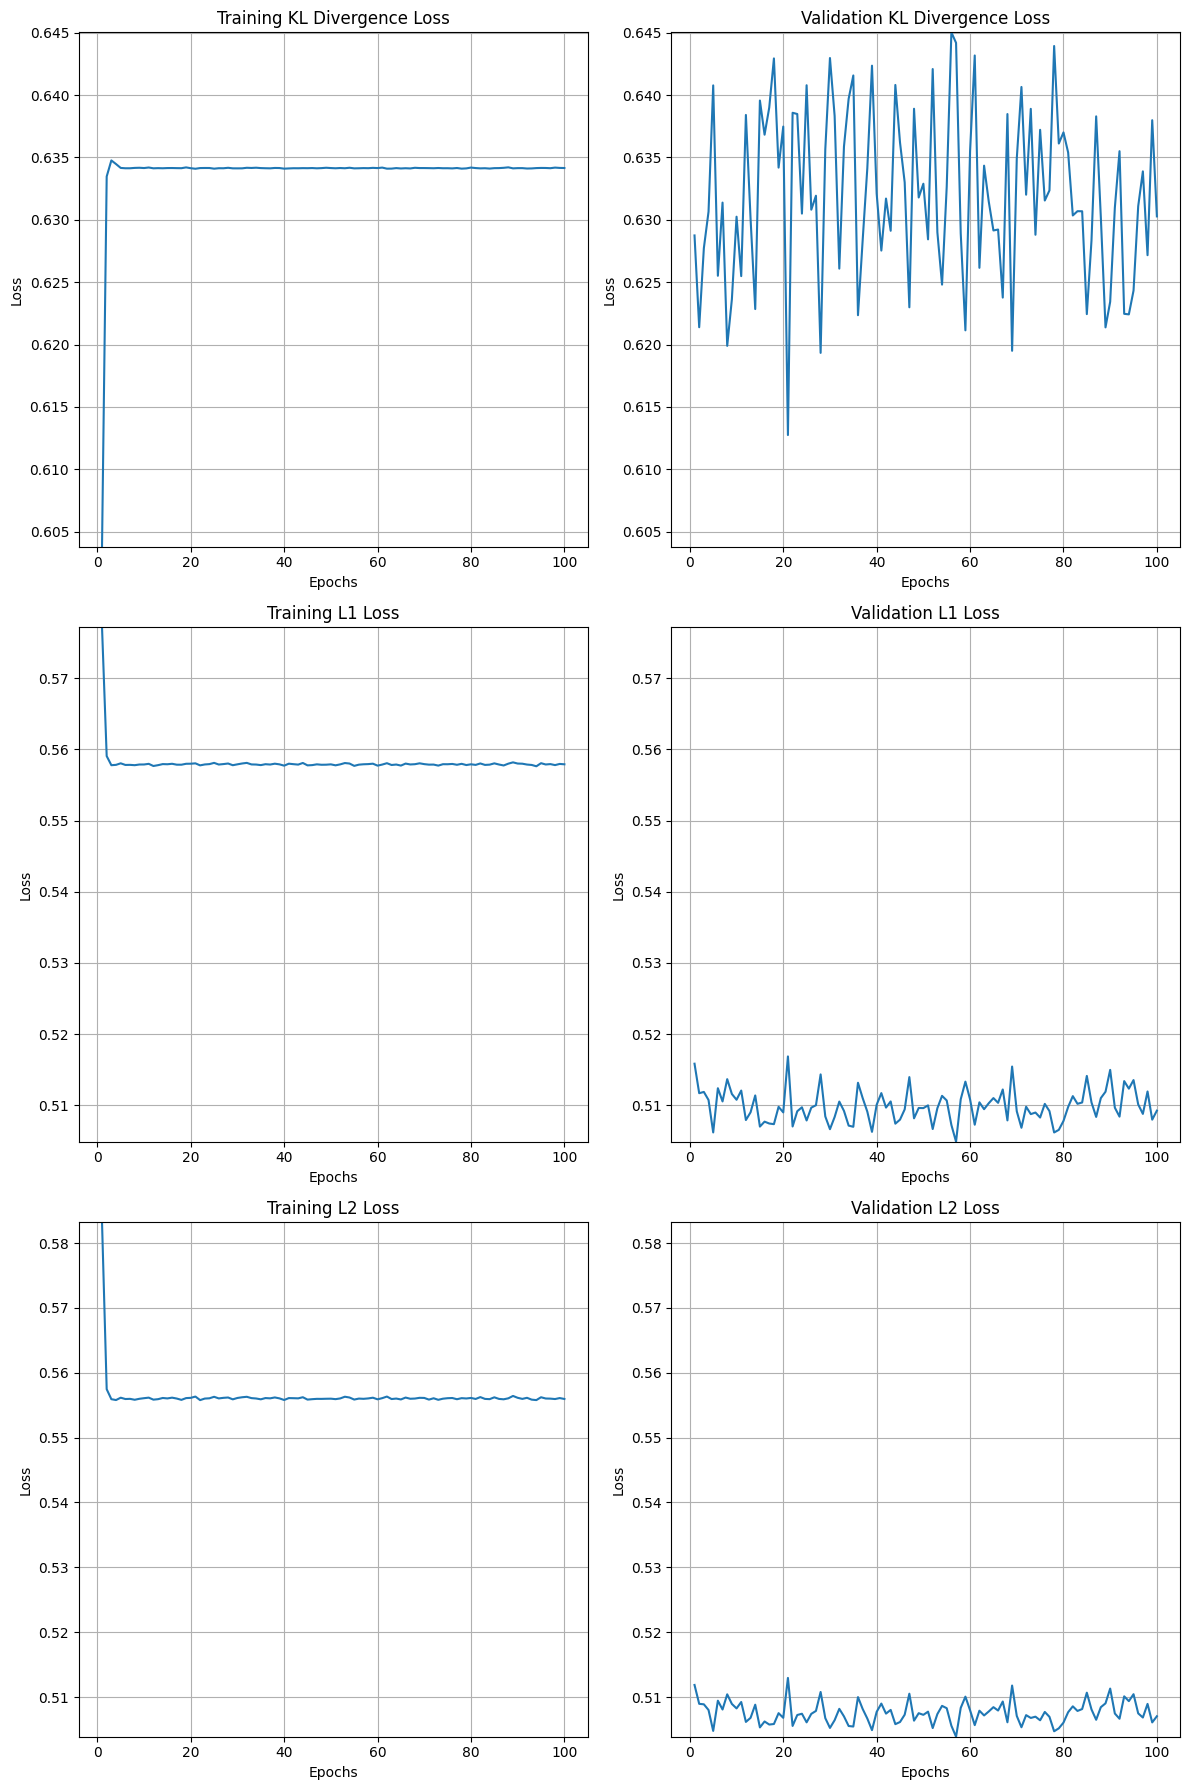

In [12]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [13]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
50.9840 K


In [14]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]


z0: -0.0114
z1: -0.0040
z2: -0.0014
z3: 0.0013


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 729.61it/s]


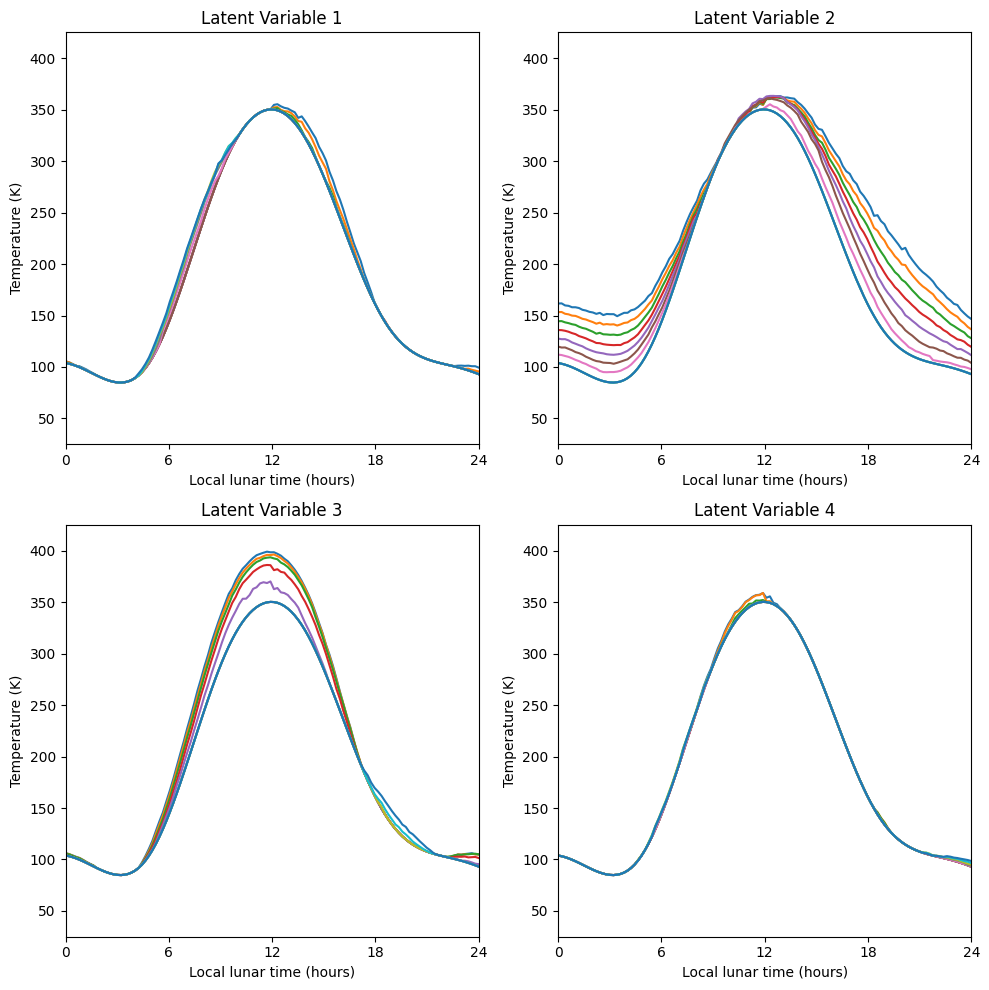

In [15]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)